In [ ]:
# fetch_sets_from_smashgg.ipynbで取得した試合情報から、イロレーティングにより各選手のシード基準値を計算して出力する

In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
pd.set_option("display.max_colwidth", 80)

In [16]:
def elo_update_value(winner_rate, loser_rate):
    """
    勝者敗者のレートを順に与えると、イロレーティングに従いレート変化量を返す
    スマメイトの変化量と比べると、稀に1だけズレる模様。指数による誤差？(ex.1574と1618で前者が勝った場合、この関数では18が出力されるがメイトでは17変化する)
    https://smashmate.net/rate/342469/
    """
    return math.ceil(32/(10**((winner_rate-loser_rate)/400)+1)) # 変化0にはしないよう切り上げ処理

In [17]:
def sturges_rule(n):
    """
    スタージェスの公式
    """
    return round(1 + math.log2(n))

In [18]:
def update_rate_dict_and_df(initial_rate_dict, df):
    """
    入力: playerTagがキーの初期レート辞書、試合データフレーム
    処理: 全試合の結果にしたがってレートを更新する
    出力: 更新後のレート辞書、レート情報データフレーム

    篝火シードがplayerTag基準でしか取れないのでplayerTagをキーとする。playerTagが重複している選手は除去する
    """

    player_rate_dict = initial_rate_dict.copy()
    diffs = []
    updated_winner_rates = []
    updated_loser_rates = []

    for winner_playerTag, loser_playerTag in zip(df["winner_playerTag"], df["loser_playerTag"]):
        diff = elo_update_value(player_rate_dict[winner_playerTag], player_rate_dict[loser_playerTag])
        player_rate_dict[winner_playerTag] += diff
        player_rate_dict[loser_playerTag] -= diff
        diffs.append(diff)
        updated_winner_rates.append(player_rate_dict[winner_playerTag])
        updated_loser_rates.append(player_rate_dict[loser_playerTag])

    df_output = pd.DataFrame({"update_value":diffs, 
                              "updated_winner_rate":updated_winner_rates,
                              "updated_loser_rate":updated_loser_rates
                             })
    
    return player_rate_dict, df_output

In [19]:
def player_rate(search_id, df_update_values):
    """
    プレイヤーIDを与えると、そのプレイヤーのレート遷移データフレームを返す
    """
    df_output = (pd.concat([df, df_update_values], axis=1)
                 .pipe(lambda x: x[(x.winner_playerId == search_id)|(x.loser_playerId == search_id)])
                 .assign(searched_player_id = search_id)
                 .assign(searched_player_name = lambda x: x.searched_player_id.map(player_id_tag_dict))
                 .assign(searched_player_rate = lambda x: np.where(x.winner_playerId == search_id, x.updated_winner_rate, x.updated_loser_rate))
                 .assign(searched_player_finalPlacement = lambda x: np.where(x.winner_playerId == search_id, x.winner_finalPlacement, x.loser_finalPlacement))
                 .assign(update_value = lambda x: np.where(x.winner_playerId == search_id, x.update_value, -x.update_value))
                 [["searched_player_id", "searched_player_name", "tournament_startday", "tournament_event_id", "bracketId", "setRound_order", "id", "tournament_JPN_name", "setRound", "winnerName", "loserName", "searched_player_rate", "update_value", "updated_winner_rate", "updated_loser_rate", "searched_player_finalPlacement", "tournament_entrants"]]
                )
    return df_output

In [32]:
# fetch_sets_from_smashgg.ipynbで出力した試合情報を読み込む

df = pd.read_csv("df_sets.csv", encoding="utf-8-sig")
df

,id,entrant1Id,entrant2Id,entrant1Name,entrant2Name,entrant1Score,entrant2Score,completed,winnerId,loserId,winnerName,loserName,setRound,bracketId,tournament_event_id,winner_tag,winner_finalPlacement,winner_seed,winner_playerId,winner_playerTag,loser_tag,loser_finalPlacement,loser_seed,loser_playerId,loser_playerTag,tournament_url,tournament_name,event_name,tournament_id,tournament_JPN_name,tournament_country,tournament_state,tournament_city,tournament_entrants,tournament_startday,tournament_endday,setRound_order
0,36244343.0,7055308.0,7044186.0,Lir,ぐんそう,2.0,0.0,True,7055308.0,7044186.0,Lir,ぐんそう,Winners Round 1,1460283.0,558662,Lir,65,54,1486058,Lir,ぐんそう,97,129,570710,ぐんそう,https://smash.gg/tournament/3-kagaribi-3/event/singles/overview,3-kagaribi-3,singles,275805,篝火#3 / Kagaribi#3,JP,東京都,大田区,132,2021-03-27,2021-03-27,11.0
1,36244415.0,7055248.0,7044186.0,Rom,ぐんそう,0.0,2.0,True,7044186.0,7055248.0,ぐんそう,Rom,Losers Round 1,1460283.0,558662,ぐんそう,97,129,570710,ぐんそう,Rom,129,81,29912,Rom,https://smash.gg/tournament/3-kagaribi-3/event/singles/overview,3-kagaribi-3,singles,275805,篝火#3 / Kagaribi#3,JP,東京都,大田区,132,2021-03-27,2021-03-27,12.0
2,36244358.0,7007280.0,7055308.0,GW | zackray,Lir,2.0,0.0,True,7007280.0,7055308.0,GW | zackray,Lir,Winners Round 2,1460283.0,558662,GW | zackray,4,1,498962,zackray,Lir,65,54,1486058,Lir,https://smash.gg/tournament/3-kagaribi-3/event/singles/overview,3-kagaribi-3,singles,275805,篝火#3 / Kagaribi#3,JP,東京都,大田区,132,2021-03-27,2021-03-27,13.0
3,36244359.0,7055285.0,7055283.0,けさん,のーまる,0.0,2.0,True,7055283.0,7055285.0,のーまる,けさん,Winners Round 2,1460283.0,558662,のーまる,65,72,2215177,のーまる,けさん,97,64,1398291,ちょけ,https://smash.gg/tournament/3-kagaribi-3/event/singles/overview,3-kagaribi-3,singles,275805,篝火#3 / Kagaribi#3,JP,東京都,大田区,132,2021-03-27,2021-03-27,13.0
4,36244360.0,7010227.0,7055273.0,Yoshimoto | Rain,Dackie,2.0,0.0,True,7010227.0,7055273.0,Yoshimoto | Rain,Dackie,Winners Round 2,1460283.0,558662,Yoshimoto | Rain,49,1,135808,Rain,Dackie,65,43,1471808,Dackie,https://smash.gg/tournament/3-kagaribi-3/event/singles/overview,3-kagaribi-3,singles,275805,篝火#3 / Kagaribi#3,JP,東京都,大田区,132,2021-03-27,2021-03-27,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33740,55221097.0,11897223.0,11898399.0,いなばっち,Danger Cat,2.0,0.0,True,11897223.0,11898399.0,いなばっち,Danger Cat,Winners Semi-Final,1925126.0,820764,いなばっち,1,2,2528015,いなばっち,Danger Cat,2,11,40454,Danger Cat,https://www.start.gg/tournament/61-sp/event/sp,61-sp,sp,499859,第61回 美らブラSP 沖縄スマブラ大会 うるま市,JP,沖縄県,うるま市,19,2022-12-18,2022-12-18,36.0
33741,55221129.0,11863945.0,11898399.0,れお,Danger Cat,0.0,2.0,True,11898399.0,11863945.0,Danger Cat,れお,Losers Semi-Final,1925126.0,820764,Danger Cat,2,11,40454,Danger Cat,れお,4,3,2770949,れお,https://www.start.gg/tournament/61-sp/event/sp,61-sp,sp,499859,第61回 美らブラSP 沖縄スマブラ大会 うるま市,JP,沖縄県,うるま市,19,2022-12-18,2022-12-18,37.0
33742,55221098.0,11863973.0,11897223.0,FTJ,いなばっち,0.0,2.0,True,11897223.0,11863973.0,いなばっち,FTJ,Winners Final,1925126.0,820764,いなばっち,1,2,2528015,いなばっち,FTJ,3,1,2712138,FTJ,https://www.start.gg/tournament/61-sp/event/sp,61-sp,sp,499859,第61回 美らブラSP 沖縄スマブラ大会 うるま市,JP,沖縄県,うるま市,19,2022-12-18,2022-12-18,39.0
33743,55221130.0,11863973.0,11898399.0,FTJ,Danger Cat,0.0,2.0,True,11898399.0,11863973.0,Danger Cat,FTJ,Losers Final,1925126.0,820764,Danger Cat,2,11,40454,Danger Cat,FTJ,3,1,2712138,FTJ,https://www.start.gg/tournament/61-sp/event/sp,61-sp,sp,499859,第61回 美らブラSP 沖縄スマブラ大会 うるま市,JP,沖縄県,うるま市,19,2022-12-18,2022-12-18,40.0


([<matplotlib.axis.XTick at 0x1ef2c56d040>,
 <a list of 11 Text major ticklabel objects>)

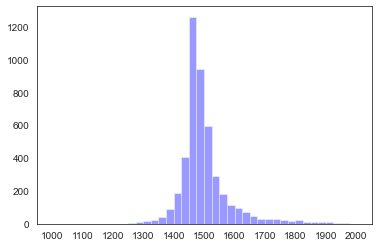

In [33]:
# 全員レート1500スタートのナイーブ手法
# 分布はいい感じだが、序盤の大会の運要素があまりに大きく、全員同レートの仮定に無理がある

naive_rate_dict, df_naive_update_values = update_rate_dict_and_df(defaultdict(lambda:1500), df)
sns.set_style(style="white")
sns.distplot(list(naive_rate_dict.values()), kde=False, color='blue', bins=list(range(1000,2025,25)))
plt.xticks(list(range(1000,2100,100)))

([<matplotlib.axis.XTick at 0x1ef2b1d9400>,
 <a list of 12 Text major ticklabel objects>)

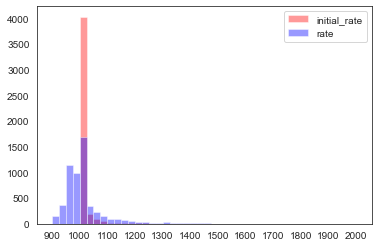

In [34]:
# 初期値用の篝火シードポイントを辞書形式で読み込み、最小値1000最大値2000に正規化し、レート遷移を求める
# 初期値が1000付近に偏りすぎていて全員1500と大して変わらない。中央値がズレるだけ

df_initial_seed = pd.read_excel("kagaribi_8_seed_point.xlsx").pipe(lambda x: x[x.dup == 1])

y1, y2 = 1000, 2000
x1, x2 = df_initial_seed.kagaribi_8_seed_point.min(), df_initial_seed.kagaribi_8_seed_point.max()
a = (y2-y1)/(x2-x1)

df_initial_seed["kagaribi_8_seed_point"] = df_initial_seed.kagaribi_8_seed_point.apply(lambda x:round(a*x + (y1-a*x1)))

initial_rate_dict = defaultdict(lambda:df_initial_seed.kagaribi_8_seed_point.median(), dict(zip(df_initial_seed.playerTag, df_initial_seed.kagaribi_8_seed_point)))

# 正規化した値を初期値としてレート計算
kagaribi_rate_dict, df_kagaribi_update_values = update_rate_dict_and_df(initial_rate_dict, df)

# 初期値と最終レートをプロット
sns.distplot(list(initial_rate_dict.values()), kde=False, bins=list(range(900,2025,25)), color='red', label="initial_rate")
sns.distplot(list(kagaribi_rate_dict.values()), kde=False, bins=list(range(900,2025,25)), color='blue', label="rate")
plt.legend()
plt.xticks(list(range(900,2100,100)))
plt.show()

13

12

([<matplotlib.axis.XTick at 0x1ef2d86b640>,
 <a list of 12 Text major ticklabel objects>)

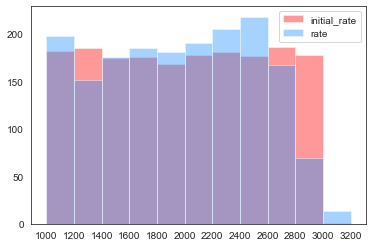

In [35]:
# 篝火シード順に順位をつけ、1,2,3位にそれぞれレート3000,2999,2998,...を割り当てていき初期値とする(同率には同じレートを割り当てる)
# 初期値未設定のプレイヤーは下位20%点からスタート
# ポイント300位が1位に勝った場合と1300位が1000位に勝った場合のレート変動がほぼ同じになってしまう

df_initial_seed = (pd.read_excel("kagaribi_8_seed_point.xlsx")
                   .pipe(lambda x: x[x.dup == 1])
                   .assign(initial_rate = lambda x:3001 - x.kagaribi_rank)
                  )
initial_rate_dict = defaultdict(lambda:df_initial_seed.initial_rate.quantile(0.2), dict(zip(df_initial_seed.playerTag, df_initial_seed.initial_rate)))
kagaribi_rate_dict, df_kagaribi_update_values = update_rate_dict_and_df(initial_rate_dict, df)

# スタージェスの公式でヒストグラムの階級数の目安を確認
sturges_rule(len(initial_rate_dict))
bins=list(range(1000,3400,200))
len(bins)

# 初期値と最終レートをプロット
sns.distplot(list(initial_rate_dict.values()), kde=False, bins=bins, color='red', label="initial_rate")
sns.distplot(list(kagaribi_rate_dict.values()), kde=False, bins=bins, color='dodgerblue', label="rate")
plt.legend()
plt.xticks(bins)
plt.savefig('rate_hist.png')
plt.show()

13

9

([<matplotlib.axis.XTick at 0x1ef2b047700>,
 <a list of 9 Text major ticklabel objects>)

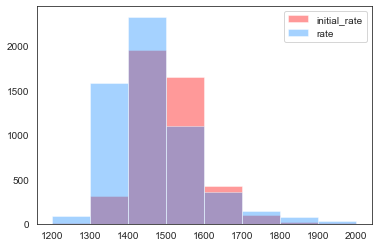

In [36]:
# スマメイト第16期と同じレート分布にする。人数を合わせてマージ
# 同シードポイントなのに異なる初期値の箇所が出ないよう、同シードポイントの最高初期値に合わせる

df_initial_seed = (pd.read_excel("kagaribi_8_seed_point.xlsx")
                   .pipe(lambda x: x[x.dup == 1])
                  )

# メイト分布に合わせてレート2400, 2300, ...の人数を割り当てる。端数は切り上げて後で調整する
df_smamate_16 = (pd.read_excel("smamate_16_rate.xlsx")
                 .assign(new_n = lambda x: (x.ratio*len(df_initial_seed)).apply(lambda y: math.ceil(y)))
                )

initial_rate_list = []
for i in range(len(df_smamate_16)):
    initial_rate_list.extend([(df_smamate_16.rate_range[i] + 1500)//2] * df_smamate_16.new_n[i])

df_initial_seed["initial_rate"] = initial_rate_list[:len(df_initial_seed)] # 端数切り上げにより超過する分をカット
    

initial_rate_dict = defaultdict(lambda:df_initial_seed.initial_rate.quantile(0.2), dict(zip(df_initial_seed.playerTag, df_initial_seed.initial_rate)))
kagaribi_rate_dict, df_kagaribi_update_values = update_rate_dict_and_df(initial_rate_dict, df)

# スタージェスの公式でヒストグラムの階級数の目安を確認
sturges_rule(len(initial_rate_dict))
bins=list(range(1200,2100,100))
len(bins)

# 初期値と最終レートをプロット
sns.distplot(list(initial_rate_dict.values()), kde=False, bins=bins, color='red', label="initial_rate")
sns.distplot(list(kagaribi_rate_dict.values()), kde=False, bins=bins, color='dodgerblue', label="rate")
plt.legend()
plt.xticks(bins)
plt.savefig('rate_hist.png')
plt.show()

count    4471.000000
mean     1483.135764
std        86.367713
min      1250.000000
25%      1450.000000
50%      1450.000000
75%      1550.000000
max      1950.000000
dtype: float64

([<matplotlib.axis.XTick at 0x1ef2e7d7cd0>,
 <a list of 9 Text major ticklabel objects>)

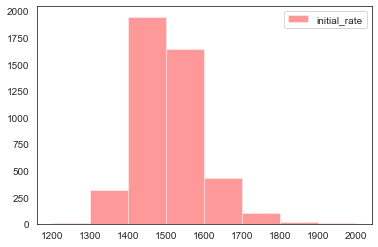

In [37]:
# 初期レートだけプロット

pd.Series(list(initial_rate_dict.values())).describe()

sns.distplot(list(initial_rate_dict.values()), kde=False, bins=bins, color='red', label="initial_rate")
plt.legend()
plt.xticks(bins)
plt.savefig('initial_rate_hist.png')
plt.show()

In [38]:
# プレイヤーマスタを読み込み、IDとtagの辞書を作る

df_players = (pd.read_csv("df_players.csv", encoding="utf-8-sig")
              [["playerId", "playerTag"]] # 大会&プレイヤー別に記録されているので、プレイヤー別に直す
              .drop_duplicates()
             )
player_id_tag_dict = dict(zip(df_players.playerId, df_players.playerTag))

In [39]:
# プレイヤーごとのレート収支をまとめたデータフレームを作る
# playerIdより少ない人数分出力される(棄権等で試合が無いプレイヤーが落ちている？)

df_player_rate = pd.DataFrame()

for player_id in tqdm(set(df_players.playerId.to_list())):
    df_player_rate = pd.concat([df_player_rate, player_rate(player_id, df_kagaribi_update_values)])

df_player_rate = (df_player_rate
                  .sort_values(["searched_player_id", "update_value"], ascending=False)
                  .assign(match_cumcount = lambda x: x.groupby('searched_player_id').cumcount()+1) # 1スタートとする
                 )

df_player_rate.to_csv("df_player_rate.csv", index=False, encoding="utf-8-sig")
df_player_rate

100%|██████████| 5115/5115 [02:49<00:00, 30.22it/s]


,searched_player_id,searched_player_name,tournament_startday,tournament_event_id,bracketId,setRound_order,id,tournament_JPN_name,setRound,winnerName,loserName,searched_player_rate,update_value,updated_winner_rate,updated_loser_rate,searched_player_finalPlacement,tournament_entrants,match_cumcount
33726,3174946,シラス,2022-12-18,820764,1925126.0,12.0,55221119.0,第61回 美らブラSP 沖縄スマブラ大会 うるま市,Losers Round 1,シラス,Crackle,1577.0,9,1577.0,1375.0,9,19,1
33721,3174946,シラス,2022-12-18,820764,1925126.0,11.0,55221088.0,第61回 美らブラSP 沖縄スマブラ大会 うるま市,Winners Round 1,いなばっち,シラス,1568.0,-18,1579.0,1568.0,9,19,2
33729,3174946,シラス,2022-12-18,820764,1925126.0,14.0,55221123.0,第61回 美らブラSP 沖縄スマブラ大会 うるま市,Losers Round 2,ワルク,シラス,1554.0,-23,1445.0,1554.0,9,19,3
33438,3171046,カｬス,2022-12-17,826121,1934531.0,13.0,55158406.0,北陸トライスマッシュ4,Winners Round 2,カｬス,まさやん,1418.0,18,1418.0,1408.0,49,96,1
33555,3171046,カｬス,2022-12-17,826121,1934554.0,4.0,55157109.0,北陸トライスマッシュ4,Round 4,カｬス,マルガリータ,1392.0,18,1392.0,1389.0,49,96,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14085,23241,Abadango,2022-05-28,722250,1751429.0,36.0,47782905.0,第29回クロブラ/神奈川スマブラ対戦会クロブラ,Winners Semi-Final,zuya,SNB | Abadango,1822.0,-25,1659.0,1822.0,17,102,145
18246,23241,Abadango,2022-06-27,739547,1783613.0,13.0,48937940.0,WINNER! #12,Winners Round 2,まちゃまっちゃ,SNB | Abadango,1807.0,-25,1654.0,1807.0,17,41,146
31964,23241,Abadango,2022-12-03,802437,1893981.0,14.0,54735727.0,西武撃/seibugeki #12,Losers Round 2,テト,SNB | Abadango,1884.0,-25,1742.0,1884.0,33,435,147
76,23241,Abadango,2021-03-27,558662,1460285.0,36.0,36244586.0,篝火#3 / Kagaribi#3,Winners Semi-Final,yuzu,SNB | Abadango,1781.0,-29,1474.0,1781.0,17,132,148


In [40]:
# チェック用

(df_player_rate[df_player_rate.searched_player_name == "おがとう"]
#  .sort_values(["tournament_startday", "tournament_event_id", "bracketId", "setRound_order", "id"])
 .assign(searched_player_rate = lambda x: x.searched_player_rate.astype(int))
 [["tournament_startday", "tournament_JPN_name", "tournament_entrants", "setRound", 'winnerName', 'loserName', 'searched_player_rate', 'update_value']]
).head(10)

,tournament_startday,tournament_JPN_name,tournament_entrants,setRound,winnerName,loserName,searched_player_rate,update_value
28803,2022-11-05,HSTSP ChampionShip Autumn Stage,143,Losers Round 5,おがとう,Rattsu,1786,13
9024,2021-12-26,HSTSP extend 2021,222,Winners Semi-Final,おがとう,れんこん,1771,12
9154,2021-12-26,HSTSP extend 2021,222,Winners Round 1,おがとう,zuya,1782,11
28796,2022-11-05,HSTSP ChampionShip Autumn Stage,143,Losers Round 4,おがとう,わにぱち,1773,11
9020,2021-12-26,HSTSP extend 2021,222,Winners Quarter-Final,おがとう,Kashiwaso,1759,9
9201,2021-12-26,HSTSP extend 2021,222,Winners Round 2,おがとう,おんちゃん,1791,9
28726,2022-11-05,HSTSP ChampionShip Autumn Stage,143,Winners Quarter-Final,おがとう,ひがし,1773,8
9260,2021-12-26,HSTSP extend 2021,222,Losers Round 7,おがとう,たま,1797,6
9264,2021-12-26,HSTSP extend 2021,222,Losers Round 8,おがとう,jyo1,1803,6
28732,2022-11-05,HSTSP ChampionShip Autumn Stage,143,Winners Round 1,おがとう,サエル,1779,6


In [41]:
# チェック用

(df_player_rate[df_player_rate.searched_player_name == "あcola"]
 .sort_values(["tournament_startday", "tournament_event_id", "bracketId", "setRound_order", "id"])
 .assign(searched_player_rate = lambda x: x.searched_player_rate.astype(int))
 [['winnerName', 'loserName', 'searched_player_rate', 'update_value']]
 .sort_values("update_value", ascending=False)
 .head(15)
 .drop(columns="searched_player_rate")
)

,winnerName,loserName,update_value
12050,あcola,Revo | Kome,19
26694,ZETA | あcola,Revo | ヨシドラ,17
15749,あcola,Revo | ヨシドラ,17
12053,あcola,8LX | HIKARU,17
15751,あcola,Revo | ヨシドラ,16
12054,あcola,8LX | HIKARU,16
30251,ZETA | あcola,Revo | Kome,13
14726,あcola,SPG | あしも,12
12044,あcola,TC有馬 | Lunamado,12
14724,あcola,PNG | シラユキ,11


In [42]:
# 試合数分布を調べる

df_tmp = (df_player_rate
          .pipe(lambda x: x[x.update_value > 0])
          .groupby("searched_player_id", as_index=False).count()
          [["searched_player_id", "id"]]
          .rename(columns={"id":"n_plus_match_per_player"})
         )

df_rate_balance = (df_player_rate
                   .groupby(["searched_player_id", "searched_player_name"], as_index=False).count()
                   [["searched_player_id", "searched_player_name", "id"]]
                   .rename(columns={"id":"n_match"})
                   .merge(df_tmp, on="searched_player_id", how="left")
                   .fillna(0)
                   .rename(columns={"searched_player_name":"playerTag"})
                    )
df_rate_balance

,searched_player_id,playerTag,n_match,n_plus_match_per_player
0,23241,Abadango,149,99.0
1,26474,TOOMUCHDOG,4,1.0
2,29847,Nasubi,26,11.0
3,29873,Kei,25,10.0
4,29912,Rom,3,0.0
...,...,...,...,...
4804,3165491,yanbarukuina,2,0.0
4805,3165648,銀二ノ介,3,0.0
4806,3165944,まいく,3,0.0
4807,3171046,カｬス,7,2.0


count    4809.000000
mean       14.034103
std        23.835091
min         1.000000
25%         3.000000
50%         6.000000
75%        13.000000
max       281.000000
Name: n_match, dtype: float64

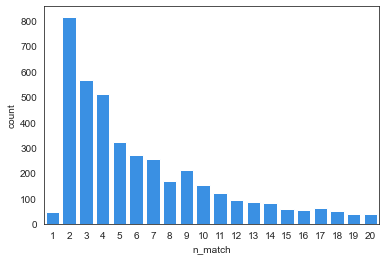

In [43]:
# 条件なしの場合、試合数の中央値は6試合と分かる

df_rate_balance.n_match.describe()
sns.countplot(x="n_match", data=df_rate_balance[df_rate_balance.n_match<=20], color='dodgerblue')
plt.savefig('n_match_hist.png')

count    4809.000000
mean        7.017051
std        15.654805
min         0.000000
25%         0.000000
50%         2.000000
75%         6.000000
max       219.000000
Name: n_plus_match_per_player, dtype: float64

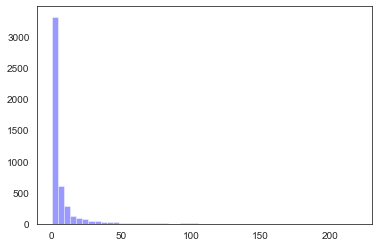

In [44]:
# レート収支黒字試合のみの場合、試合数の中央値は2試合と分かる

df_rate_balance.n_plus_match_per_player.describe()
sns.distplot(df_rate_balance.n_plus_match_per_player.to_list(), kde=False, color='blue')

In [45]:
# レート収支降順ソートした後に所定の試合数だけ各プレイヤーから抽出し、レート更新値を計算し直す
# searched_player_nameで集計すると同名プレイヤーが合成されてしまうので注意

n_pickup_match = 10

df_update = (df_player_rate
             .pipe(lambda x: x[x.match_cumcount <= n_pickup_match])
             .groupby(["searched_player_id", "searched_player_name"], as_index=False).sum()
             [["searched_player_id", "searched_player_name", "update_value"]]
             .rename(columns={"searched_player_id":"playerId", "searched_player_name":"playerTag"})
             .sort_values("update_value", ascending=False)
             .assign(playerTag_count = lambda x:x.groupby("playerTag")["playerTag"].transform("count")) # playerTag重複数
            )
df_update

,playerId,playerTag,update_value,playerTag_count
2123,2485238,かえる,267,2
1017,1497801,Neo,264,1
109,498179,Nao,254,1
1779,2237419,かじん,252,1
895,1478572,ヒデヨシ,252,2
...,...,...,...,...
3199,2757310,やけくそブッパマン,-126,1
4196,2954955,ウッチャン,-130,1
3270,2776879,こた,-131,1
1720,2227847,もっさん,-131,2


In [46]:
# 結果をプレイヤーごとのデータフレームに直し出力する

df_rate = (df_update
            .pipe(lambda x: x[x.playerTag_count == 1]) # playerTag重複プレイヤーには意味のない数値をマージしていくので一旦絞る
            .assign(initial_rate = lambda x: x.playerTag.map(initial_rate_dict)) # 初期レート追加
            .merge(df_rate_balance[["playerTag", "n_match"]].drop_duplicates("playerTag"), on="playerTag", how="left") # 試合数追加
            .assign(n_match = lambda x: x.n_match.astype(int))
            .assign(update_value = lambda x: x.update_value.astype(int))
            .assign(rate = lambda x: (x.initial_rate + x.update_value).astype(int))
            .sort_values("rate", ascending=False)
            .merge(pd.read_excel("kagaribi_8_seed_point.xlsx")
                  .pipe(lambda x: x[x.dup == 1]) # playerTagが重複しているプレイヤーは除いて篝火シードと順位をマージ
                  [["playerTag", "kagaribi_8_seed_point", "kagaribi_rank"]]
                  ,on="playerTag", how="left")
            .fillna(-1) # 篝火シードと順位をマージできなかった箇所にintのダミー値を挿入。最初から"-"を挿入すると後のnp.whereでエラー
            .assign(new_rank = lambda x: x.rate.rank(ascending=False, method='min').astype(int))
            .assign(rank_diff = lambda x: np.where(x.kagaribi_rank == -1, "-", (x.kagaribi_rank - x.new_rank).astype(int)))
            .assign(kagaribi_8_seed_point = lambda x: np.where(x.kagaribi_rank == -1, "-", x.kagaribi_8_seed_point))
            .assign(kagaribi_rank = lambda x: np.where(x.kagaribi_rank == -1, "-", x.kagaribi_rank))
            [["playerTag", 'rate', "new_rank", "kagaribi_rank", "rank_diff", "n_match", 'initial_rate', 'update_value', 'kagaribi_8_seed_point', "playerId"]]
          )

# playerTag重複プレイヤーだけ縦結合
df_rate = pd.concat([df_rate, 
                    (df_update
                     .pipe(lambda x: x[x.playerTag_count >= 2])
                     .drop(columns=["playerTag_count"])
                     .assign(new_rank = "-")
                     .assign(kagaribi_rank = "-")
                     .assign(rank_diff = "-")
                     .assign(n_match = "-")
                     .assign(initial_rate = "-")
                     .assign(rate = "-")
                     .assign(kagaribi_8_seed_point = "-")
                    )])

df_rate.to_csv("df_rate.csv", index=False, encoding="utf-8-sig")
df_rate

,playerTag,rate,new_rank,kagaribi_rank,rank_diff,n_match,initial_rate,update_value,kagaribi_8_seed_point,playerId
0,あcola,2100,1,1.0,0,66,1950,150,2518792.0,2691639
1,ミーヤー,2098,2,2.0,0,60,1900,198,2264139.0,1636582
2,ヨシドラ,2078,3,3.0,0,116,1900,178,1857318.0,1151910
3,Shuton,2061,4,4.0,0,126,1900,161,1631015.0,226829
4,Kameme,2059,5,6.0,1,116,1850,209,1479995.0,197485
...,...,...,...,...,...,...,...,...,...,...
4353,マコト,-,-,-,-,-,-,-102,-,3011094
1840,がぶ,-,-,-,-,-,-,-103,-,2321272
4089,ともしび,-,-,-,-,-,-,-104,-,2932548
1926,たか,-,-,-,-,-,-,-112,-,2336501


In [47]:
# 表示を整形したバージョンを出力する

(df_rate
 .rename(columns={"playerId":"プレイヤーID",
                  'playerTag':"プレイヤー名",
                  'rate':"最終レート",
                  'new_rank':"スマメイト方式シード順位",
                  'kagaribi_rank':"篝火シード順位",
                  'rank_diff':"順位変動",
                  "n_match":"算入試合数",
                  'initial_rate':"初期レート",
                  'update_value':"レート変動",
                  'kagaribi_8_seed_point':"篝火シードポイント"})
 .to_csv("スマメイト方式_篝火シード.csv", index=False, encoding="utf-8-sig")
)

df_rate

,playerTag,rate,new_rank,kagaribi_rank,rank_diff,n_match,initial_rate,update_value,kagaribi_8_seed_point,playerId
0,あcola,2100,1,1.0,0,66,1950,150,2518792.0,2691639
1,ミーヤー,2098,2,2.0,0,60,1900,198,2264139.0,1636582
2,ヨシドラ,2078,3,3.0,0,116,1900,178,1857318.0,1151910
3,Shuton,2061,4,4.0,0,126,1900,161,1631015.0,226829
4,Kameme,2059,5,6.0,1,116,1850,209,1479995.0,197485
...,...,...,...,...,...,...,...,...,...,...
4353,マコト,-,-,-,-,-,-,-102,-,3011094
1840,がぶ,-,-,-,-,-,-,-103,-,2321272
4089,ともしび,-,-,-,-,-,-,-104,-,2932548
1926,たか,-,-,-,-,-,-,-112,-,2336501


13

10

([<matplotlib.axis.XTick at 0x1ef2eab4c10>,
 <a list of 10 Text major ticklabel objects>)

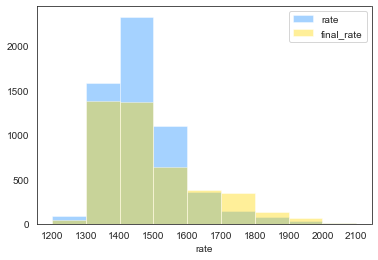

In [48]:
# 遷移後レートと最終レートを比較する

# スタージェスの公式でヒストグラムの階級数の目安を確認
sturges_rule(len(kagaribi_rate_dict))
bins=list(range(1200,2200,100))
len(bins)

sns.distplot(list(kagaribi_rate_dict.values()), kde=False, bins=bins, color='dodgerblue', label="rate")
sns.distplot(df_rate[df_rate != "-"].rate, kde=False, bins=bins, color='gold', label="final_rate")
plt.legend()
plt.xticks(bins)
plt.savefig('final_rate_hist.png')
plt.show()

In [49]:
# 試合データを整形して出力

(df_player_rate
 .sort_values(["searched_player_id", "tournament_startday", "tournament_event_id", "bracketId", "setRound_order", "id"])
 [['searched_player_name', 'searched_player_rate', 'update_value', 'winnerName', 'loserName', 
   'tournament_startday', 'tournament_JPN_name', 'tournament_entrants', 'setRound', 
    'searched_player_id',]]
 .rename(columns={"searched_player_id":"プレイヤーID",
                  'searched_player_name':"プレイヤー名",
                  'tournament_startday':"大会開催日",
                  'tournament_JPN_name':"大会名",
                  'tournament_entrants':"大会参加者数",
                  'setRound':"回戦",
                  "winnerName":"勝者",
                  'loserName':"敗者",
                  'searched_player_rate':"試合後レート",
                  'update_value':"レート変化"})
 .to_csv("試合データ.csv", index=False, encoding="utf-8-sig")
)